In [ ]:
! git clone --recursive https://github.com/Microsoft/LightGBM
! cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;

!pip install numerapi
!pip install halo
!pip install wandb
!pip install catboost

!git clone https://github.com/numerai/example-scripts
!cp /content/example-scripts/utils.py /content/

Cloning into 'LightGBM'...
remote: Enumerating objects: 23644, done.
remote: Counting objects: 100% (1320/1320), done.
remote: Compressing objects: 100% (739/739), done.
remote: Total 23644 (delta 830), reused 923 (delta 550), pack-reused 22324
Receiving objects: 100% (23644/23644), 18.24 MiB | 22.64 MiB/s, done.
Resolving deltas: 100% (17223/17223), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/LightGBM/external_libs/compute'...
remote: Enumerating objects: 21733, done.        
remote: Counting objects: 100% (5/5), done.        
remote: 

**Restart runtime**

This notebook is built on top of the excellent [`example_model.py`](https://github.com/numerai/example-scripts/blob/master/example_model.py)

The [`example-scripts`](https://github.com/numerai/example-scripts) has the `utils.py` which has some very helpful functions to load, evaluate, and neutralize data. 

In [ ]:
import gc
import os
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import numerapi
import random
import pandas as pd
import pickle
import seaborn as sns
import wandb
import glob, joblib

from halo import Halo
from lightgbm import LGBMRegressor
from numerapi import NumerAPI
from tqdm.auto import tqdm
from utils import (
    save_model,
    load_model,
    neutralize,
    get_biggest_change_features,
    validation_metrics,
    download_data,
)
from wandb.lightgbm import wandb_callback

# Warningの無効化
import warnings
warnings.filterwarnings("ignore")

# データフレームcolumの全表示
pd.set_option("display.max_columns", None)

# Set seed for reproducability
seed = 42
random.seed(seed)
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

tqdm.pandas()

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Data Loading

In [ ]:
napi = NumerAPI()
spinner = Halo(text="", spinner="dots")

current_round = napi.get_current_round(tournament=8)  # tournament 8 is the primary Numerai Tournament

# read in all of the new datas
# tournament data and example predictions change every week so we specify the round in their names
# training and validation data only change periodically, so no need to download them over again every single week
napi.download_dataset("numerai_tournament_data_int8.parquet", "numerai_tournament_data_int8.parquet")
napi.download_dataset("numerai_training_data_int8.parquet", f"numerai_training_data_int8.parquet")
napi.download_dataset("numerai_validation_data_int8.parquet", f"numerai_validation_data_int8.parquet")
napi.download_dataset("example_predictions.parquet", f"example_predictions_{current_round}.parquet")
napi.download_dataset("example_validation_predictions.parquet", "example_validation_predictions.parquet")
napi.download_dataset("example_predictions.csv", "example_predictions.csv")

2021-10-27 22:30:59,835 INFO numerapi.utils: starting download
numerai_tournament_data_int8.parquet: 582MB [00:34, 16.6MB/s]                           
2021-10-27 22:31:36,245 INFO numerapi.utils: starting download
numerai_training_data_int8.parquet: 1.01GB [01:27, 11.6MB/s]                            
2021-10-27 22:33:05,035 INFO numerapi.utils: starting download
numerai_validation_data_int8.parquet: 228MB [00:14, 15.5MB/s]                           
2021-10-27 22:33:20,710 INFO numerapi.utils: starting download
example_predictions_287.parquet: 33.5MB [00:03, 9.14MB/s]                            
2021-10-27 22:33:26,126 INFO numerapi.utils: starting download
example_validation_predictions.parquet: 13.0MB [00:01, 6.53MB/s]                            
2021-10-27 22:33:29,119 INFO numerapi.utils: starting download
example_predictions.csv: 51.2MB [00:04, 11.4MB/s]                            


In [ ]:
spinner.start("Reading parquet data")
training_data = pd.read_parquet("numerai_training_data_int8.parquet")
# removing the 
eras = [i for i in range(1, len(training_data.era.unique())+1, 4)]
training_data = training_data[training_data.era.astype(int).isin(eras)]
gc.collect()
tournament_data = pd.read_parquet(f"numerai_tournament_data_int8.parquet")
gc.collect()
validation_data = pd.read_parquet("numerai_validation_data_int8.parquet")
gc.collect()
example_preds = pd.read_parquet(f"example_predictions_{current_round}.parquet")
gc.collect()
validation_preds = pd.read_parquet("example_validation_predictions.parquet")
gc.collect()
spinner.succeed()

✔ Reading parquet data


In [ ]:
training_data

era data_type  feature_dichasial_hammier_spawner  \
id                                                                    
n003bba8a98662e4  0001     train                                  4   
n003bee128c2fcfc  0001     train                                  2   
n0048ac83aff7194  0001     train                                  2   
n00691bec80d3e02  0001     train                                  4   
n00b8720a2fdc4f2  0001     train                                  4   
...                ...       ...                                ...   
nffc2d5e4b79a7ae  0573     train                                  1   
nffc7d24176548a4  0573     train                                  4   
nffc9844c1c7a6a9  0573     train                                  4   
nffd79773f4109bb  0573     train                                  1   
nfff87b21e4db902  0573     train                                  3   

                  feature_rheumy_epistemic_prancer  \
id                                                   
n003bba8a98662e4                                 2   
n003bee128c2fcfc                                 4   
n0048ac83aff7194                                 1   
n00691bec80d3e02                                 2   
n00b8720a2fdc4f2                                 3   
...                                            ...   
nffc2d5e4b79a7ae                                 2   
nffc7d24176548a4                                 2   
nffc9844c1c7a6a9                                 3   
nffd79773f4109bb                                 3   
nfff87b21e4db902                                 3   

                  feature_pert_performative_hormuz  \
id                                                   
n003bba8a98662e4                                 4   
n003bee128c2fcfc                                 1   
n0048ac83aff7194                                 3   
n00691bec80d3e02                                 2   
n00b8720a2fdc4f2                                 4   
...                                            ...   
nffc2d5e4b79a7ae                                 3   
nffc7d24176548a4                                 3   
nffc9844c1c7a6a9                                 3   
nffd79773f4109bb                                 0   
nfff87b21e4db902                                 2   

                  feature_hillier_unpitied_theobromine  \
id                                                       
n003bba8a98662e4                                     4   
n003bee128c2fcfc                                     3   
n0048ac83aff7194                                     0   
n00691bec80d3e02                                     3   
n00b8720a2fdc4f2                                     4   
...                                                ...   
nffc2d5e4b79a7ae                                     2   
nffc7d24176548a4                                     4   
nffc9844c1c7a6a9                                     4   
nffd79773f4109bb                                     2   
nfff87b21e4db902                                     2   

                  feature_perigean_bewitching_thruster  \
id                                                       
n003bba8a98662e4                                     0   
n003bee128c2fcfc                                     0   
n0048ac83aff7194                                     3   
n00691bec80d3e02                                     0   
n00b8720a2fdc4f2                                     0   
...                                                ...   
nffc2d5e4b79a7ae                                     3   
nffc7d24176548a4                                     2   
nffc9844c1c7a6a9                                     1   
nffd79773f4109bb                                     2   
nfff87b21e4db902                                     1   

                  feature_renegade_undomestic_milord  \
id                                                     
n003bba8a98662e4                                   0   
n003bee128c

In [ ]:
EXAMPLE_PREDS_COL = "example_preds"
validation_data[EXAMPLE_PREDS_COL] = validation_preds["prediction"]

TARGET_COL = "target"
ERA_COL = "era"

target = "target"
targets = [c for c in training_data if c.startswith("target")]

# all feature columns start with the prefix "feature_"
feature_cols = [c for c in training_data if c.startswith("feature_")]

gc.collect()

50

## EDA

In [ ]:
wandb.init(project="massive_nmr", name="plots")

wandb: Currently logged in as: _whitecat_22 (use `wandb login --relogin` to force relogin)


In [ ]:
all_target_corrs = (
    training_data.groupby("era")
    .apply(lambda d: d[targets].corrwith(d[TARGET_COL]))
    .iloc[:, 1:]
)

# selecting the most and least correlated targets to the scoring target
top_targets = list(all_target_corrs.mean(0).sort_values(ascending=False)[:7].index)
bottom_targets = list(all_target_corrs.mean(0).sort_values(ascending=False)[-2:].index)

# using only 7 most correlated targets
useful_targets = top_targets  # + bottom_targets

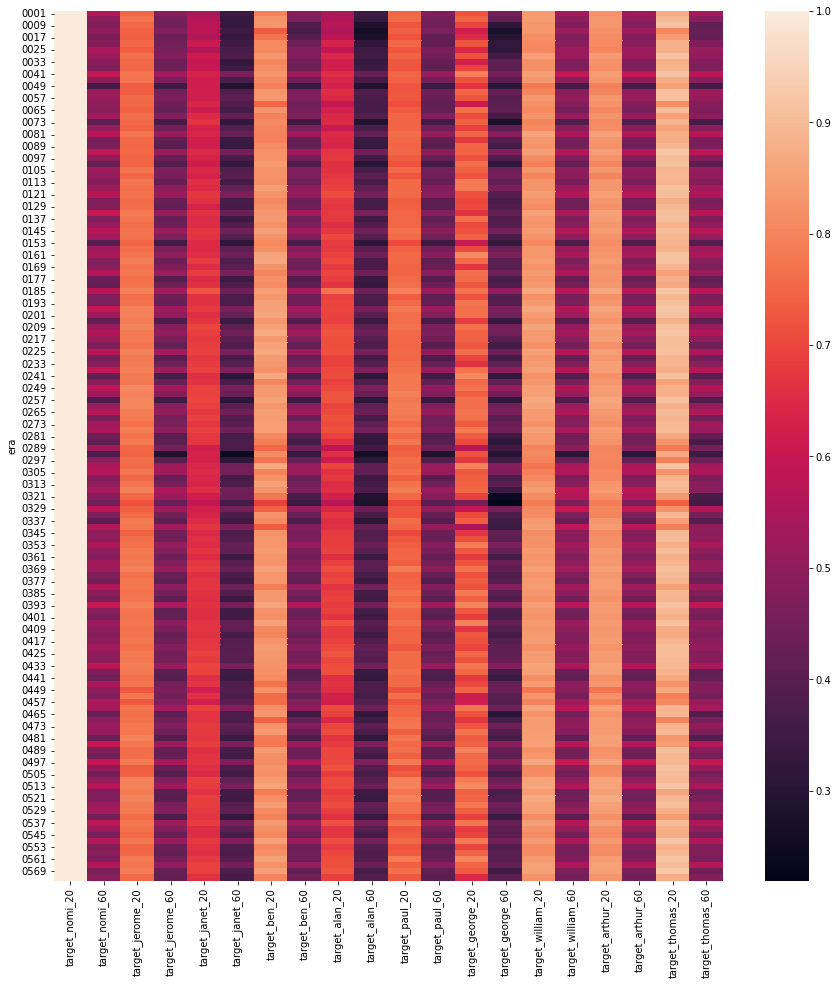

In [ ]:
fig, ax = plt.subplots(figsize=(15, 16))
sns.heatmap(data=all_target_corrs, ax=ax)
fig.savefig("era_wise_target_corr.png")
wandb.log({"targets_corr": wandb.Image("era_wise_target_corr.png")})

In [ ]:
# finding the most correlated(to scoring target) features across all eras 
all_feature_corrs = training_data.groupby("era").apply(lambda d: d[feature_cols].corrwith(d[TARGET_COL]))
abs_corr = all_feature_corrs.mean().abs().sort_values(ascending=False)[:len(feature_cols)]

# usign only 50% of most correlated(to scoring target) features to reduce memory usage
top_features = abs_corr[:int(len(abs_corr)*0.5)].index

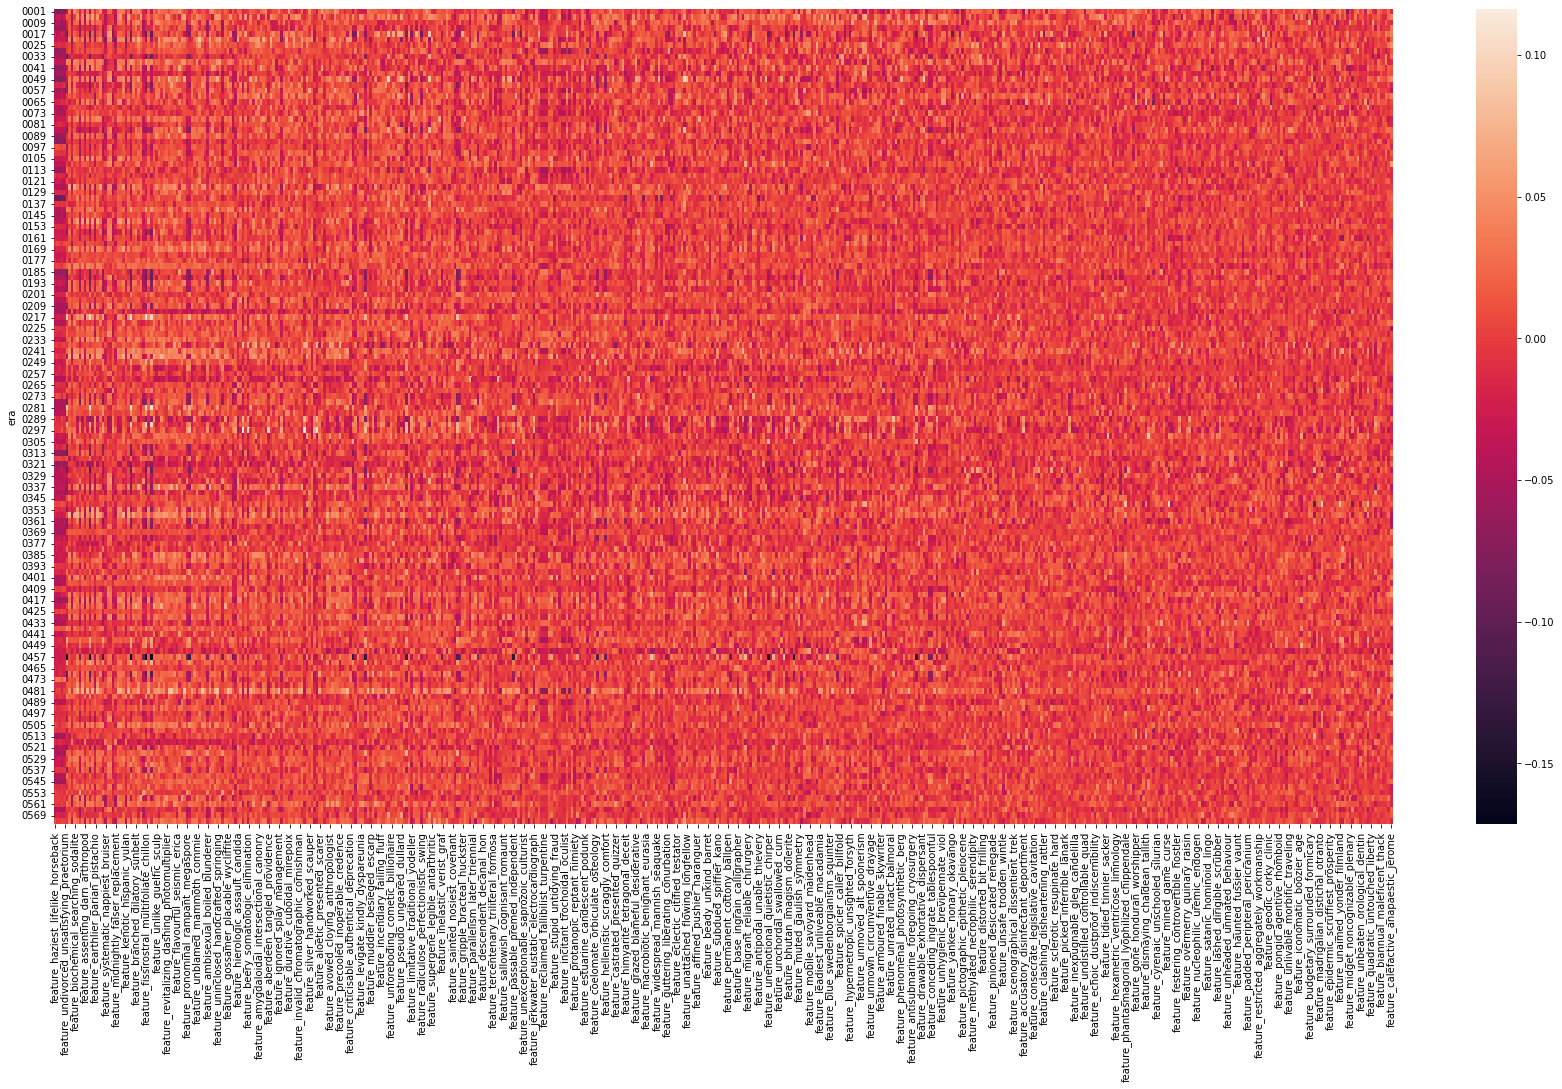

In [ ]:
fig, ax = plt.subplots(figsize=(30, 15))
sns.heatmap(data=all_feature_corrs[top_features], ax=ax)
fig.savefig("era_wise_feature_corr.png")
wandb.log({"feature_corr": wandb.Image("era_wise_feature_corr.png")})

## Training 
### Ensemble on targets

In [ ]:
models_ = {}

for target_ in tqdm(useful_targets):
    gc.collect()
    wandb.init(project="massive_nmr", name=f"tgt_{target_}")
    lgb_train = lgb.Dataset(
        training_data[top_features].values,
        np.array(training_data[target_].values, dtype=np.float),
    )
    lgb_eval = lgb.Dataset(
        validation_data[top_features].values,
        np.array(validation_data[target_].values, dtype=np.float),
        reference=lgb_train,
    )

    model_name = f"model_gbm_{target_}"

    # TODO: try different parameters
    params = {
        "n_estimators": 1000,
        "num_leaves": 2 ** 5,
        "device": "gpu",
    }

    model = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_eval],
        verbose_eval=100,
        callbacks=[wandb_callback()],
    )

    models_[model_name] = model
    gc.collect()

  0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2625
[LightGBM] [Info] Number of data points in the train set: 604111, number of used features: 525
[LightGBM] [Info] Using GPU Device: Tesla V100-SXM2-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 525 dense feature groups (152.10 MB) transferred to GPU in 0.158463 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 0.499996
[100]	valid_0's l2: 0.0500475
[200]	valid_0's l2: 0.0501044
[300]	valid_0's l2: 0.0501463
[400]	valid_0's l2: 0.0501998
[500]	valid_0's l2: 0.0502286
[600]	valid_0's l2: 0.0502623
[700]	valid_0's l2: 0.0503063
[800]	valid_0's l2: 0.0503478
[900]	valid_0's l2: 0.0503923
[1000]	valid_0's l2: 0.0504384


valid_0_l2,▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
valid_0_l2,0.05044


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2625
[LightGBM] [Info] Number of data points in the train set: 604111, number of used features: 525
[LightGBM] [Info] Using GPU Device: Tesla V100-SXM2-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 525 dense feature groups (152.10 MB) transferred to GPU in 0.154980 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 0.499819
[100]	valid_0's l2: 0.0337079
[200]	valid_0's l2: 0.033743
[300]	valid_0's l2: 0.0337708
[400]	valid_0's l2: 0.0337937
[500]	valid_0's l2: 0.0338313
[600]	valid_0's l2: 0.0338593
[700]	valid_0's l2: 0.0338799
[800]	valid_0's l2: 0.0339056
[900]	valid_0's l2: 0.0339315
[1000]	valid_0's l2: 0.0339539


valid_0_l2,▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇████
valid_0_l2,0.03395


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2625
[LightGBM] [Info] Number of data points in the train set: 604111, number of used features: 525
[LightGBM] [Info] Using GPU Device: Tesla V100-SXM2-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 525 dense feature groups (152.10 MB) transferred to GPU in 0.160885 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 0.504550
[100]	valid_0's l2: 0.042791
[200]	valid_0's l2: 0.042829
[300]	valid_0's l2: 0.0428646
[400]	valid_0's l2: 0.0429094
[500]	valid_0's l2: 0.0429498
[600]	valid_0's l2: 0.0429906
[700]	valid_0's l2: 0.0430234
[800]	valid_0's l2: 0.0430611
[900]	valid_0's l2: 0.0430926
[1000]	valid_0's l2: 0.0431217


valid_0_l2,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
valid_0_l2,0.04312


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2625
[LightGBM] [Info] Number of data points in the train set: 604111, number of used features: 525
[LightGBM] [Info] Using GPU Device: Tesla V100-SXM2-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 525 dense feature groups (152.10 MB) transferred to GPU in 0.155943 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 0.478464
[100]	valid_0's l2: 0.0422631
[200]	valid_0's l2: 0.0423034
[300]	valid_0's l2: 0.0423444
[400]	valid_0's l2: 0.0423732
[500]	valid_0's l2: 0.0424227
[600]	valid_0's l2: 0.0424612
[700]	valid_0's l2: 0.0424949
[800]	valid_0's l2: 0.0425367
[900]	valid_0's l2: 0.0425695
[1000]	valid_0's l2: 0.0425991


valid_0_l2,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
valid_0_l2,0.0426


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2625
[LightGBM] [Info] Number of data points in the train set: 604111, number of used features: 525
[LightGBM] [Info] Using GPU Device: Tesla V100-SXM2-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 525 dense feature groups (152.10 MB) transferred to GPU in 0.152346 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 0.499983
[100]	valid_0's l2: 0.0495978
[200]	valid_0's l2: 0.0496462
[300]	valid_0's l2: 0.0496792
[400]	valid_0's l2: 0.0497156
[500]	valid_0's l2: 0.0497558
[600]	valid_0's l2: 0.0497994
[700]	valid_0's l2: 0.0498269
[800]	valid_0's l2: 0.0498611
[900]	valid_0's l2: 0.0498968
[1000]	valid_0's l2: 0.0499348


valid_0_l2,▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇████
valid_0_l2,0.04993


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2625
[LightGBM] [Info] Number of data points in the train set: 604111, number of used features: 525
[LightGBM] [Info] Using GPU Device: Tesla V100-SXM2-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 525 dense feature groups (152.10 MB) transferred to GPU in 0.152756 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 0.499964
[100]	valid_0's l2: 0.0507971
[200]	valid_0's l2: 0.0508336
[300]	valid_0's l2: 0.0508683
[400]	valid_0's l2: 0.0509071
[500]	valid_0's l2: 0.0509359
[600]	valid_0's l2: 0.0509734
[700]	valid_0's l2: 0.0510129
[800]	valid_0's l2: 0.0510491
[900]	valid_0's l2: 0.0510847
[1000]	valid_0's l2: 0.0511239


valid_0_l2,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid_0_l2,0.05112


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2625
[LightGBM] [Info] Number of data points in the train set: 604111, number of used features: 525
[LightGBM] [Info] Using GPU Device: Tesla V100-SXM2-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 525 dense feature groups (152.10 MB) transferred to GPU in 0.152996 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 0.499231
[100]	valid_0's l2: 0.0487103
[200]	valid_0's l2: 0.0487299
[300]	valid_0's l2: 0.0487558
[400]	valid_0's l2: 0.0487751
[500]	valid_0's l2: 0.0488033
[600]	valid_0's l2: 0.0488265
[700]	valid_0's l2: 0.0488533
[800]	valid_0's l2: 0.0488849
[900]	valid_0's l2: 0.0489172
[1000]	valid_0's l2: 0.0489508


In [ ]:
# saving the model and the feature names used inside "model" directory
if not os.path.exists("models"):
    os.mkdir("models")

for model_ in models_:
    models_[model_].save_model(os.path.join("models", f"{model_}.txt"))
joblib.dump(top_features, os.path.join("models", "model_expected_features.pkl"))

['models/model_expected_features.pkl']

In [ ]:
# syncing the saved files to wandb run as artifacts 
# this makes downloading them at inference easy 
run = wandb.init(project="massive_nmr", job_type="train")

artifact = wandb.Artifact("models", type="model")
artifact.add_dir("models")

run.log_artifact(artifact)

valid_0_l2,█▂▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃
valid_0_l2,0.04895


wandb: Adding directory to artifact (./models)... Done. 0.3s


## Prediction

In [ ]:
# check for nans and fill nans
if tournament_data.loc[tournament_data["data_type"] == "live", feature_cols].isna().sum().sum():
    cols_w_nan = tournament_data.loc[tournament_data["data_type"] == "live", feature_cols].isna().sum()
    total_rows = tournament_data[tournament_data["data_type"] == "live"]
    print(f"Number of nans per column this week: {cols_w_nan[cols_w_nan > 0]}")
    print(f"out of {total_rows} total rows")
    print(f"filling nans with 0.5")
    tournament_data.loc[:, feature_cols].fillna(0.5, inplace=True)
else:
    print("No nans in the features this week!")

No nans in the features this week!


In [ ]:
# loading the saved artifacts form wandb run for inference 
# ucomment for loading artifacts for inference
# you can use the saved artifacts to load models so no need to retrain every week

"""
run = wandb.init(project="massive_nmr")
artifact = run.use_artifact("<username>/massive_nmr/models:latest", type="model")
artifact_dir = artifact.download(root="artifacts")

model_files = glob.glob("model*.txt")
print(model_files)

top_features = joblib.load("model_expected_features.pkl")
models_ = {}
for model_file in model_files:
    target_name = model_file[:-4]
    print(target_name)
    models_[target_name] = lgb.Booster(model_file=model_file)
"""

'\nrun = wandb.init(project="massive_nmr")\nartifact = run.use_artifact(\'<username>/massive_nmr/models:latest\', type=\'model\')\nartifact_dir = artifact.download(root="artifacts")\n\nmodel_files = glob.glob("model*.txt")\nprint(model_files)\n\ntop_features = joblib.load("model_expected_features.pkl")\nmodels_ = {}\nfor model_file in model_files:\n    target_name = model_file[:-4]\n    print(target_name)\n    models_[target_name] = lgb.Booster(model_file=model_file)\n'

In [ ]:
# prediction on validation and tournamnet data
val_preds = pd.DataFrame(index=validation_data.index)
tournament_preds = pd.DataFrame(index=tournament_data.index)

for model_ in tqdm(models_):

    val_preds.loc[:, f"preds_{model_}"] = models_[model_].predict(
        validation_data[top_features], num_iteration=models_[model_].best_iteration
    )
    tournament_preds.loc[:, f"preds_{model_}"] = models_[model_].predict(
        tournament_data[top_features], num_iteration=models_[model_].best_iteration
    )
    gc.collect()

validation_data = pd.concat([validation_data, val_preds], 1)
models_to_validate = ["preds_" + m for m in models_]

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
# final model will be using average of all predictions 
model_name="ensemble"
validation_data.loc[:, f"preds_{model_name}"] = val_preds.iloc[:, :].mean(1)
tournament_data.loc[:, f"preds_{model_name}"] = tournament_preds.iloc[:, :].mean(1)

In [ ]:
# using validation function from example_script
# evaluate all selected columns in validation_data

validation_stats = validation_metrics(
    validation_data,
    models_to_validate + [f"preds_{model_name}"],
    example_col=EXAMPLE_PREDS_COL,
    fast_mode=True,
)
validation_stats

2021-10-27 22:41:50,824 INFO numexpr.utils: NumExpr defaulting to 8 threads.


,mean,std,sharpe,max_drawdown,apy,mmc_mean,corr_plus_mmc_sharpe,corr_with_example_preds
preds_model_gbm_target_nomi_20,0.015682,0.024007,0.653226,-0.193276,111.408088,0.003476,0.519397,0.439414
preds_model_gbm_target_thomas_20,0.013715,0.024936,0.550007,-0.192529,92.058672,0.002865,0.423200,0.395368
preds_model_gbm_target_william_20,0.019068,0.026412,0.721939,-0.161558,148.186351,0.006224,0.621778,0.431437
preds_model_gbm_target_arthur_20,0.018981,0.028136,0.674631,-0.175908,146.620340,0.006128,0.578367,0.432375
preds_model_gbm_target_ben_20,0.015920,0.023726,0.671020,-0.151089,113.939208,0.004402,0.556544,0.402825
preds_model_gbm_target_jerome_20,0.020199,0.026099,0.773957,-0.150946,162.159386,0.006994,0.691994,0.437723
preds_model_gbm_target_paul_20,0.010798,0.019023,0.567634,-0.133926,67.812582,0.001695,0.404321,0.335329
preds_ensemble,0.022706,0.030029,0.756129,-0.231321,194.146493,0.006017,0.650184,0.584274


We can see training on all a few targets and combining them shows higher correlation mean with better mmc and APY. 

This can be improved even further using Neutralization. Let"s see how that affects.

### Neutralization and evaluation

Since the features are non-stationary and can change the target correlation on era basis, neutralization reduces the linear exposure of selected features from the predictions. Thus, reducing the standard deviation and improving Sharpe ratio. 

Below is neutralizing against 50 most volatile features with 0.5 proportion. 

In [ ]:
spinner.start("Neutralizing to risky features")
# getting the per era correlation of each feature vs the target
all_feature_corrs = training_data.groupby(ERA_COL).apply(
    lambda d: d[feature_cols].corrwith(d[TARGET_COL])
)

# find the riskiest features by comparing their correlation vs the target in half 1 and half 2 of training data
riskiest_features = get_biggest_change_features(all_feature_corrs, 50)

# neutralize our predictions to the riskiest features
validation_data[f"preds_{model_name}_neutral_riskiest_50"] = neutralize(
    df=validation_data,
    columns=[f"preds_{model_name}"],
    neutralizers=riskiest_features,
    proportion=0.5,
    normalize=True,
    era_col=ERA_COL,
)

tournament_data[f"preds_{model_name}_neutral_riskiest_50"] = neutralize(
    df=tournament_data,
    columns=[f"preds_{model_name}"],
    neutralizers=riskiest_features,
    proportion=0.5,
    normalize=True,
    era_col=ERA_COL,
)
spinner.succeed()


✔ Neutralizing to risky features


In [ ]:
# model_to_submit = f"preds_{model_name}" # non neutralized predicitions
model_to_submit = f"preds_{model_name}_neutral_riskiest_50"  # neutralized predictions

validation_data["prediction"] = validation_data[model_to_submit].rank(pct=True)
tournament_data["prediction"] = tournament_data[model_to_submit].rank(pct=True)
validation_data["prediction"].to_csv(f"validation_predictions_{current_round}.csv")
tournament_data["prediction"].to_csv(f"tournament_predictions_{current_round}.csv")

# get some stats about each of our models to compare...
# fast_mode=True so that we skip some of the stats that are slower to calculate
validation_stats = validation_metrics(
    validation_data, [model_to_submit], example_col=EXAMPLE_PREDS_COL, fast_mode=True
)
validation_stats

,mean,std,sharpe,max_drawdown,apy,mmc_mean,corr_plus_mmc_sharpe,corr_with_example_preds
preds_ensemble_neutral_riskiest_50,0.024898,0.029029,0.857681,-0.212229,227.158908,0.006831,0.767637,0.628878


In [ ]:
public_id = "<PUBLIC_ID>"
secret_key = "<SECRET_KEY>"
model_id = "<MODEL_ID>"

napi = numerapi.NumerAPI(public_id, secret_key)
napi.upload_predictions(f"tournament_predictions_{current_round}.csv",
                        model_id=model_id, version=2)

2021-10-27 22:44:02,094 INFO numerapi.base_api: uploading predictions...
2021-10-27 22:44:02,384 ERROR numerapi.base_api: Your session is invalid or has expired.


ValueError: ignored